| Model                            | train_loss | val_loss | test_loss | version |
|----------------------------------|------------|----------|-----------|---------|
| Initial                          |     2.0914 |   6.4632 |    1.2512 |      V1 |
| Initial (normalized)             |     0.1155 |   0.4484 |    4.7467 |       - |
| Weekday Factor (non-learnable)   |          - |        - |    4.2924 |      V4 |
| Weekday Factor Model             |     1.7337 |   6.2968 |    1.2501 |      V5 |
| Fusion Fashion (concat)          |     4.4311 |   2.0399 |    1.4001 |      V9 |
| Fusion Fashion (add)             |     4.4655 |   2.0404 |    1.5238 |     V10 |
| Fusion Fashion (product)         |     4.4871 |   2.0026 |    2.6962 |     V11 |
| Deep Component (MLP)             |     1.5269 |   5.9076 |    1.2485 |     V13 |
| Deep Component (LSTM)            |     1.9411 |   6.4934 |    1.3774 |     V14 |
| Deep Component (CNN)             |     4.5718 |   2.1301 |    1.2506 |     V19 |
| Deep Component (CNN+LSTM)        |     1.9860 |   6.5012 |    1.4712 |     V16 |
| DeepFM                           |     4.6230 |   1.6574 |    1.2211 |     V21 |
| Seasonal Decompose Model         |     4.8107 |   1.7076 |    5.4404 |     V24 |
| Manaul Statics Model             |     4.5980 |   1.3547 |    1.2643 |     V26 |

In [ ]:
# Read data and aggregate into monthly data

import pandas as pd

train_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
# columns: date, date_block_num, shop_id, item_id, item_price, item_cnt_day
train_monthly_df = train_df.groupby(['date_block_num','shop_id','item_id']).agg(sale_cnt_month=('item_cnt_day','sum'),price_month=('item_price','mean')).reset_index()
train_monthly_df['shop_item'] = train_monthly_df['shop_id'].astype('string') + '-' + train_monthly_df['item_id'].astype('string')
shop_item_list = pd.unique(train_monthly_df['shop_item'])
shop_list = pd.unique(train_monthly_df['shop_id'])
item_list = pd.unique(train_monthly_df['item_id'])

print("count of shop_item:",len(shop_item_list))
print('------')
print('count of shop_id:', len(shop_list))
print('min shop_id:', min(shop_list))
print('max shop id:', max(shop_list))
print('------')
print('count item_id:', len(item_list))
print('min item_id:', min(item_list))
print('max item id:', max(item_list))
train_monthly_df

In [ ]:
# get the "sale_cnt sequences" of each "shop_item"
## get (data_seq_dict)

import numpy as np

data_seq_dict = {}
for shop_item in shop_item_list:
    data_seq_dict[shop_item] = [0.0 for i in range(0,34)]
for _, row in train_monthly_df.iterrows():
    data_seq_dict[row['shop_item']][int(row['date_block_num'])] = row['sale_cnt_month']
    
print(len(data_seq_dict))

In [ ]:
# get the "last price" of each "shop_item" as the future price
## shopitem_price_dict

import random

shopitem_price_dict = {}  # {shop_item: [avg_price, current_max_date_block_num, cnt]}
# record price and max date_block_num of each shop_item
for _, row in train_monthly_df.iterrows():
    if row['shop_item'] not in shopitem_price_dict.keys():
        shopitem_price_dict[row['shop_item']] = [row['price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > shopitem_price_dict[row['shop_item']][1]:
            shopitem_price_dict[row['shop_item']] = [row['price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == shopitem_price_dict[row['shop_item']][1]:
            entry = shopitem_price_dict[row['shop_item']]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['price_month']) / count
            shopitem_price_dict[row['shop_item']] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [shop_item, price_month]
for k,v in shopitem_price_dict.items():
    shopitem_price_dict[k] = v[0]

# UT code: printout a random sample to check
print(len(shopitem_price_dict))
idx = random.randint(0,len(shop_item_list))
shop_item = shop_item_list[idx]
print("The last price of shop-item", shop_item, ":", shopitem_price_dict[shop_item])
shop_item = shop_item.split('-')
train_monthly_df[(train_monthly_df['shop_id']==int(shop_item[0])) &
                 (train_monthly_df['item_id']==int(shop_item[1])) &
                 (train_monthly_df['price_month']>0.0)].sort_values(by=['date_block_num'],ascending=[False])

In [ ]:
# get the avg "sale_cnt sequences" of each "item" as default
# In case the shop_item in test dataset does not appear in training dataset, 
# we use the "item avg sale_cnt sequence" as default.
## get (item_seq_dict)

item_seq_dict = {}
item_seq_num_dict = {}
# make sum
for k, v in data_seq_dict.items():
    item = k.split('-')[1]
    if item not in item_seq_dict.keys():
        item_seq_dict[item] = v
        item_seq_num_dict[item] = 1
    else:
        item_seq_dict[item] = [i+j for i, j in zip(item_seq_dict[item], v)]
        item_seq_num_dict[item] += 1
# make average
for item in item_seq_dict.keys():
    item_seq_dict[item] = [element / item_seq_num_dict[item] for element in item_seq_dict[item]]

print(len(item_seq_dict))

In [ ]:
# get the "last price" of each "item" as the future price
## get (item_price_dict)

item_price_dict = {}  # {item_id: [avg_price, current_max_date_block_num, cnt]}
# record prices and max date_block_num of each item
for _, row in train_monthly_df.iterrows():
    item_id = str(row['item_id'])
    if item_id not in item_price_dict.keys():
        item_price_dict[item_id] = [row['price_month'], row['date_block_num'], 1]
    else:
        if row['date_block_num'] > item_price_dict[item_id][1]:
            item_price_dict[item_id] = [row['price_month'], row['date_block_num'], 1]
        if row['date_block_num'] == item_price_dict[item_id][1]:
            entry = item_price_dict[item_id]
            count = entry[2] + 1
            price = (entry[0] * entry[2] + row['price_month']) / count
            item_price_dict[item_id] = [price, row['date_block_num'], count]
# remove date_block_num and count in the dict to only keep [item_id, price_month]
for k,v in item_price_dict.items():
    item_price_dict[k] = v[0]
    
# UT code: printout a random sample to check
print(len(item_price_dict))
idx = random.randint(0,len(item_list))
item_id = str(item_list[idx])
print("The last price of item", item_id, ":", item_price_dict[item_id])
tmp_df = train_monthly_df[(train_monthly_df['item_id']==int(item_id))][['date_block_num', 'price_month']]
tmp_df = tmp_df[tmp_df['date_block_num']==tmp_df['date_block_num'].max()][['price_month']].mean()
print(tmp_df)

In [ ]:
# Data Preprocess

import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K


# parameter
ITEM_VOCAB_LEN = 1000

# Scaler of price
price_scaler = MinMaxScaler(feature_range=(0,1))
price_scaler.fit([[i] for i in train_monthly_df['price_month'].tolist()])

# Split X and Y
X = []
Y = []
for k,v in data_seq_dict.items():
    shop_item = k
    static_vec = np.array([int(i) for i in k.split('-')])
    static_vec[1] = static_vec[1] % ITEM_VOCAB_LEN
    price_vec = price_scaler.transform([[shopitem_price_dict[k]]]).reshape((-1,))
    static_vec = np.concatenate([static_vec, price_vec])
    seq_vec = np.array(v).reshape((-1,1))  # (steps, 1)
    X.append([shop_item, static_vec, seq_vec[:-1,:]])
    Y.append(seq_vec[-1,:])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
X_train_static = np.array([x[1] for x in X_train])
X_train_seq = np.array([x[2] for x in X_train])
Y_train = np.array(Y_train)
X_val_static = np.array([x[1] for x in X_val])
X_val_seq = np.array([x[2] for x in X_val])
Y_val = np.array(Y_val)

# Global Parameters
STEPS = X_train_seq.shape[1]

print("Training Dataset:")
print("\nX_train_static:")
print(X_train_static.shape)
print(X_train_static)
print("\nX_train_seq:")
print(X_train_seq.shape)
print(X_train_seq)
print("\nY_train:")
print(Y_train.shape)
print(Y_train)
print("\nValidation Dataset:")
print("\nX_val_static:")
print(X_val_static.shape)
print(X_val_static)
print("\nX_val_seq:")
print(X_val_seq.shape)
print(X_val_seq)
print("\nY_val:")
print(Y_val.shape)
print(Y_val)

In [ ]:
# # Initial Model, Wide&Deep

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

# deep_vec = LSTM(units=4, name='LSTM')(input_seq_vec)

# # Fusion Layer
# output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [ ]:
# # Weekday Factor Model

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization, Multiply
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

# deep_vec = LSTM(units=4, name='LSTM')(input_seq_vec)

# # Fusion Layer
# model_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# model_vec = Dense(units=1, activation='relu')(model_vec)

# # Weekday Factor Component
# # 1. calculate the Weekday Factor
# value_4week_vec = Lambda(lambda x: tf.slice(x, (0,STEPS-28,0), (-1,28,-1)), name='Weekday_Factor')(input_seq_vec)  # (N, 28, 1)
# value_4week_vec = Reshape((4,7))(value_4week_vec)  # (N, 4 ,7)
# week_mean_vec = Lambda(lambda x: tf.reduce_mean(x, axis=2, keepdims=True))(value_4week_vec)  # (N, 4, 1)
# day_factor_vec = Lambda(lambda x: tf.math.divide_no_nan(x[0],x[1]))([value_4week_vec,week_mean_vec])  # (N, 4, 7)
# weekday_factor_vec = Lambda(lambda x: tf.reduce_mean(x, axis=1))(day_factor_vec)  # (N, 7)
# # 2. calculate the Base (mean of last 3 weeks)
# value_3week_vec = Lambda(lambda x: tf.slice(x, (0,STEPS-21,0), (-1,21,-1)), name='base')(input_seq_vec)  # (N, 28, 1)
# value_3week_vec = Reshape((21,))(value_3week_vec)  # (N, 28)
# base_vec = Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(value_3week_vec)  # (N, 1)
# # 3. make predicrion (weekday_factor * base)
# weekday_factor_vec = Multiply()([weekday_factor_vec, base_vec])  # (N, 7)
# weekday_factor_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(weekday_factor_vec)  # (N, 1)

# # Output Layer
# output_vec = Concatenate(axis=-1, name='output_Concat')([model_vec, weekday_factor_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [ ]:
# # Fusion Fashion Model (concat/add/product)

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization, Multiply
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])  # (N, 9)

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))

# deep_vec = LSTM(units=9, name='LSTM')(input_seq_vec)  # (N, 9)

# # Fusion Layer
# # output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# # output_vec = Add(name='Concat_fusion')([wide_vec, deep_vec])
# # output_vec = Multiply(name='Concat_fusion')([wide_vec, deep_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [ ]:
# # Deep Component (MLP/LSTM/CNN/CNN+LSTM)

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization, AveragePooling1D, MaxPool1D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))

# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])  # (N,9)

# # Deep Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))
# # # MLP
# # deep_vec = Flatten()(input_seq_vec)
# # deep_vec = Dense(units=16, activation='relu')(deep_vec)
# # deep_vec = Dense(units=8, activation='relu')(deep_vec)
# # # LSTM
# # deep_vec = LSTM(units=8, name='LSTM')(input_seq_vec)
# # CNN
# deep_vec = Conv1D(filters=3,kernel_size=3,strides=2,padding='valid',name='Conv_1')(input_seq_vec)  # (N,16,3)
# deep_vec = AveragePooling1D(pool_size=2,strides=None,padding='valid',name='Pooling_1')(deep_vec)  # (N,8,3)
# deep_vec = Conv1D(filters=2,kernel_size=5,strides=1,padding='valid',name='Conv_2')(deep_vec)  # (N,4,2)
# deep_vec = Flatten()(deep_vec)
# # # CNN+LSTM
# # deep_vec = Conv1D(filters=3,kernel_size=3,strides=1,padding='valid',name='Conv_1')(input_seq_vec)  # (N,31,3)
# # deep_vec = LSTM(units=8, name='LSTM')(deep_vec)  # (N,8)

# # Fusion Layer
# output_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# output_vec = Dense(units=1, activation='relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [ ]:
# # DeepFM

# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization, CategoryEncoding
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error


# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 


# # MODEL
# # input
# input_static_vec = Input(name='input_static', shape = (3,))
# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)

# # one-hot
# shop_onehot_vec = CategoryEncoding(num_tokens=60, output_mode='one_hot', sparse=False)(shop_vec)
# item_onehot_vec = CategoryEncoding(num_tokens=ITEM_VOCAB_LEN, output_mode='one_hot', sparse=False)(item_vec)
# onehot_vec = Concatenate(axis=-1, name='one_hot')([shop_onehot_vec, item_onehot_vec, price_vec])

# # order-1
# order_1_vec = Dense(units=1, activation=None)(onehot_vec)  # (N,1)

# # embedding
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_emb_vec = Dense(units=4, activation=None)(price_vec)
# emb_vec = Concatenate(axis=-1, name='emb')([shop_emb_vec, item_emb_vec, price_emb_vec])

# # order-2
# # sum_square
# sum_square_vec = Lambda(lambda x: tf.square(tf.reduce_sum(x, axis=-1)), name='sum_square')(emb_vec)
# # square_sum
# square_sum_vec = Lambda(lambda x: tf.reduce_sum(tf.square(x), axis=-1), name='square_sum')(emb_vec)
# # compute
# order_2_vec = Lambda(lambda x: 0.5 * tf.subtract(x[0],x[1]), name='Order_2')([sum_square_vec,square_sum_vec])  # (N,1)

# # FM output
# FM_output_vec = Add()([order_1_vec, order_2_vec])  # (N,1)

# # high-order
# order_high_vec = Dense(units=4, activation='relu')(emb_vec)
# order_high_vec = Dense(units=4, activation='relu')(order_high_vec)
# order_high_vec = Dense(units=1, activation='relu')(order_high_vec)  # (N,1)

# # Seq Component
# input_seq_vec = Input(name='input_seq', shape = (STEPS,1))
# seq_vec = LSTM(units=1, name='LSTM')(input_seq_vec)  # (N,1)

# # Fusion Layer
# output_vec = Add(name='output')([FM_output_vec, order_high_vec, seq_vec])  # (N,1)
# output_vec = Activation('relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [ ]:
# # Seasonal Decompose Model 

# # Preprocess data

# from statsmodels.tsa.seasonal import seasonal_decompose

# # Train data
# X_train_trend = []
# X_train_seasonal = []
# X_train_resid = []
# for x in X_train_seq:
#     result = seasonal_decompose(x, period=12, model='additive', extrapolate_trend='freq')
#     X_train_trend.append(result.trend)
#     X_train_seasonal.append([result.seasonal[-12]])
#     X_train_resid.append([sum(result.resid) / len(result.resid)])
# X_train_trend = np.stack(X_train_trend)
# X_train_seasonal = np.array(X_train_seasonal)
# X_train_resid = np.array(X_train_resid)

# # Validation data
# X_val_trend = []
# X_val_seasonal = []
# X_val_resid = []
# for x in X_val_seq:
#     result = seasonal_decompose(x, period=12, model='additive', extrapolate_trend='freq')
#     X_val_trend.append(result.trend)
#     X_val_seasonal.append([result.seasonal[-12]])
#     X_val_resid.append([sum(result.resid) / len(result.resid)])
# X_val_trend = np.stack(X_val_trend)
# X_val_seasonal = np.array(X_val_seasonal)
# X_val_resid = np.array(X_val_resid)



# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# from math import log
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow import feature_column
# from tensorflow.nn import relu
# from tensorflow.keras import backend as K
# from tensorflow.keras.models import Sequential
# from tensorflow.keras import Model
# from tensorflow.keras import Input
# from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import mean_squared_error

# # Loss
# def root_mean_squared_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# # Model
# # Wide Component
# input_static_vec = Input(name='input_static', shape = (3,))
# shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
# shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
# shop_emb_vec = Flatten()(shop_emb_vec)
# item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
# item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
# item_emb_vec = Flatten()(item_emb_vec)
# price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
# wide_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# # Deep Component
# input_trend_vec = Input(name='input_trend', shape = (STEPS,1))
# deep_vec = LSTM(units=4, name='LSTM')(input_trend_vec)

# # Fusion Layer
# trend_vec = Concatenate(axis=-1, name='Concat_fusion')([wide_vec, deep_vec])
# trend_vec = Dense(units=1, activation='relu')(trend_vec)

# # Output Layer
# input_seasonal_vec = Input(name='input_seasonal', shape = (1,))
# input_resid_vec = Input(name='input_resid', shape = (1,))
# output_vec = Add()([trend_vec,input_seasonal_vec,input_resid_vec])
# output_vec = Activation('relu')(output_vec)

# model = Model(inputs=[input_static_vec,input_trend_vec,input_seasonal_vec,input_resid_vec], outputs=[output_vec])
# model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
# model.summary()

# callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
#                                               verbose=1, mode='min', patience=3,
#                                               restore_best_weights=True)]

# history = model.fit(x={'input_static': X_train_static, 
#                        'input_trend': X_train_trend, 
#                        'input_seasonal': X_train_seasonal, 
#                        'input_resid': X_train_resid}, 
#                     y=Y_train,
#                     validation_data=({'input_static':X_val_static,
#                                       'input_trend':X_val_trend,
#                                       'input_seasonal':X_val_seasonal,
#                                       'input_resid':X_val_resid}, 
#                                      Y_val), 
#                     epochs=100, 
#                     batch_size=1024*1024,
#                     callbacks=callbacks)

In [47]:
# Manual Statics Model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from math import log
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import feature_column
from tensorflow.nn import relu
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Lambda, Concatenate, Reshape, Embedding, Conv1D, Add, Flatten, LSTM, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

# Loss
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Model
# Wide component
input_static_vec = Input(name='input_static', shape = (3,))
shop_vec = Lambda(lambda x: tf.slice(x, (0,0), (-1,1)))(input_static_vec)
shop_emb_vec = Embedding(input_dim=60, output_dim=4, input_length=(1,))(shop_vec)
shop_emb_vec = Flatten()(shop_emb_vec)
item_vec = Lambda(lambda x: tf.slice(x, (0,1), (-1,1)))(input_static_vec)
item_emb_vec = Embedding(input_dim=ITEM_VOCAB_LEN, output_dim=4, input_length=(1,))(item_vec)
item_emb_vec = Flatten()(item_emb_vec)
price_vec = Lambda(lambda x: tf.slice(x, (0,2), (-1,1)))(input_static_vec)
static_vec = Concatenate(axis=-1, name='Concat_wide')([shop_emb_vec, item_emb_vec, price_vec])

# Deep Component
input_seq_vec = Input(name='input_seq', shape = (STEPS,1))
input_seq_2d_vec = Flatten()(input_seq_vec)
# lastest seq
latest_seq_vec = Lambda(lambda x: tf.slice(x, (0,STEPS-3,0), (-1,3,-1)), name='latest_seq')(input_seq_vec)
latest_seq_vec = LSTM(units=1, name='LSTM')(latest_seq_vec)
# last weekday
last_weekday_vec = Lambda(lambda x: tf.divide(tf.slice(x, (0,STEPS-7), (-1,1)) + tf.slice(x, (0,STEPS-14), (-1,1)),2), name='last_weekday')(input_seq_2d_vec)
# week mean
week_mean_vec = Lambda(lambda x: tf.reduce_mean(tf.slice(x, (0,STEPS-7), (-1,7)),axis=-1,keepdims=True),name='week_mean')(input_seq_2d_vec)
# recent mean
recent_mean_vec = Lambda(lambda x: tf.reduce_mean(tf.slice(x, (0,STEPS-3), (-1,3)),axis=-1,keepdims=True),name='recent_mean')(input_seq_2d_vec)

# Fusion Layer
output_vec = Concatenate(axis=-1, name='Concat_fusion')([static_vec, latest_seq_vec, last_weekday_vec, week_mean_vec, recent_mean_vec])
output_vec = Dense(units=1, activation='relu')(output_vec)

model = Model(inputs=[input_static_vec,input_seq_vec], outputs=[output_vec])
model.compile(loss=root_mean_squared_error, optimizer=Adam(learning_rate=0.05))
model.summary()

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001,
                                              verbose=1, mode='min', patience=3,
                                              restore_best_weights=True)]

history = model.fit(x={'input_static': X_train_static, 'input_seq': X_train_seq}, 
                    y=Y_train,
                    validation_data=({'input_static':X_val_static,'input_seq':X_val_seq}, Y_val), 
                    epochs=100, 
                    batch_size=1024*1024,
                    callbacks=callbacks)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_static (InputLayer)       [(None, 3)]          0                                            
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 1)            0           input_static[0][0]               
__________________________________________________________________________________________________
lambda_72 (Lambda)              (None, 1)            0           input_static[0][0]               
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 1, 4)         240         lambda_71[0][0]                  
____________________________________________________________________________________________

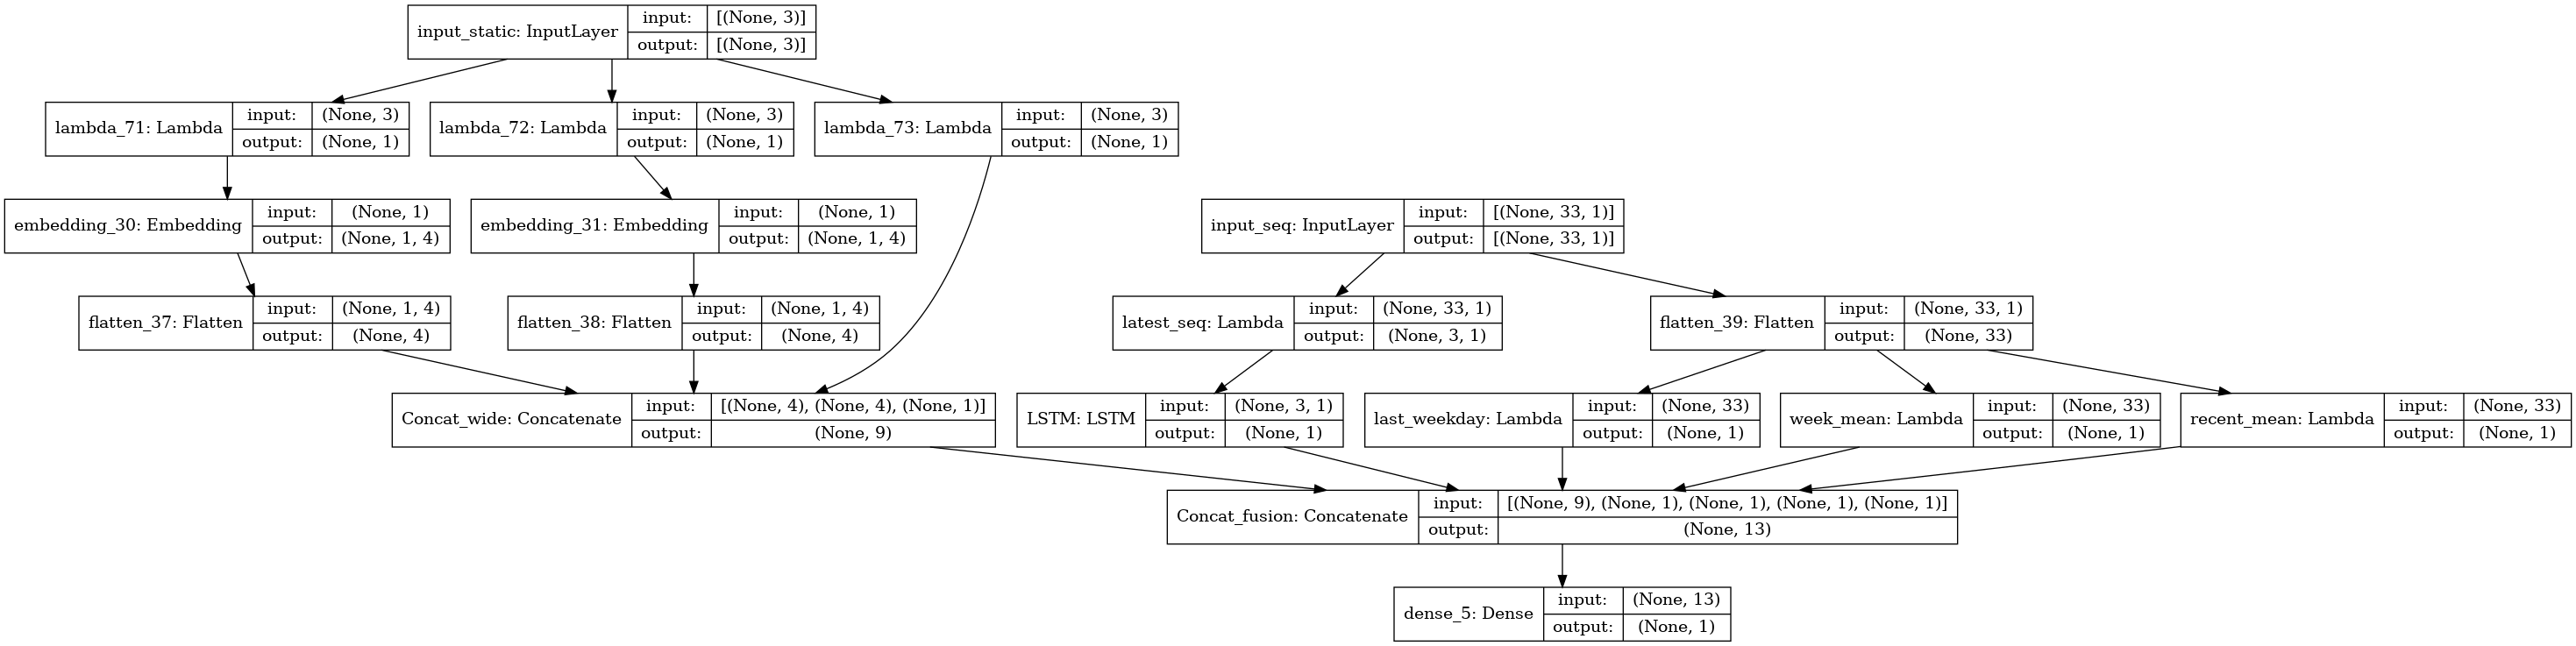

In [48]:
tf.keras.utils.plot_model(model, to_file='model_graph.png', show_shapes=True, show_layer_names=True)

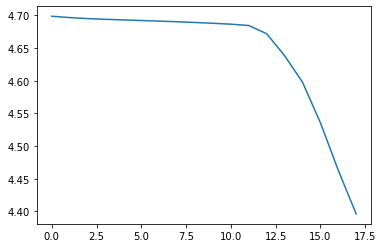

In [49]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.show()

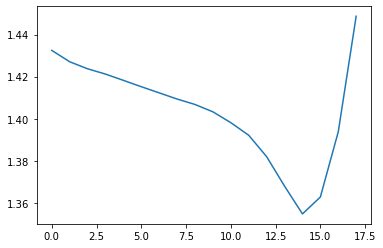

In [50]:
plt.plot(history.history['val_loss'])
plt.show()

In [52]:
# Prepare Test dataset

test_df = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv').set_index('ID')
test_df['shop_item'] = test_df['shop_id'].astype('string') + '-' + test_df['item_id'].astype('string')

X_test_static = []
X_test_seq = []
for _, row in test_df.iterrows():
    shop_item = row['shop_item']
    shop_id = str(row['shop_id'])
    item_id = str(row['item_id'])
    
    # get sale_cnt_seq
    if shop_item in data_seq_dict.keys():
        sale_cnt_seq = data_seq_dict[shop_item][1:]
    else:
        if item_id in item_seq_dict.keys():
            sale_cnt_seq = item_seq_dict[item_id][1:]
        else:
            sale_cnt_seq = [0.0 for i in range(0,STEPS)]
    
    # get price
    if shop_item in shopitem_price_dict.keys():
        price = shopitem_price_dict[shop_item]
    else:
        if item_id in item_price_dict.keys():
            price = item_price_dict[item_id]
        else:
            price = 0.0
    
    # generate the sample
    static_vec = np.array([int(shop_id), int(item_id) % ITEM_VOCAB_LEN])
    price_vec = price_scaler.transform([[price]]).reshape((-1,))
    static_vec = np.concatenate([static_vec, price_vec])
    seq_vec = np.array(sale_cnt_seq).reshape((-1,1))  # (steps, 1)
    X_test_static.append(static_vec)
    X_test_seq.append(seq_vec)
X_test_static = np.array(X_test_static)
X_test_seq = np.array(X_test_seq)


print('X_test_static:')
print(X_test_static.shape)
print(X_test_static)
print('\nX_test_seq:')
print(X_test_seq.shape)
print(X_test_seq)

X_test_static:
(214200, 3)
[[ 5.00000000e+00  3.70000000e+01  2.43330807e-03]
 [ 5.00000000e+00  3.20000000e+02 -2.92226853e-07]
 [ 5.00000000e+00  2.33000000e+02  3.89281885e-03]
 ...
 [ 4.50000000e+01  7.57000000e+02  6.45853816e-04]
 [ 4.50000000e+01  6.48000000e+02  2.99727343e-04]
 [ 4.50000000e+01  9.69000000e+02  1.78229158e-03]]

X_test_seq:
(214200, 33, 1)
[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [3.        ]
  [1.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [1.        ]
  [3.        ]
  [1.        ]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.36842105]
  [0.15789474]
  [0.10526316]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]


In [53]:
pred = model.predict({'input_static':X_test_static, 'input_seq':X_test_seq})
print(pred.shape)
print(pred)

# # Seasonal Decompose Model
# # proprocess data
# X_test_trend = []
# X_test_seasonal = [] 
# X_test_resid = []
# for x in X_test_seq:
#     result = seasonal_decompose(x, period=12, model='additive', extrapolate_trend='freq')
#     X_test_trend.append(result.trend)
#     X_test_seasonal.append([result.seasonal[-12]])
#     X_test_resid.append([sum(result.resid) / len(result.resid)])
# X_test_trend = np.stack(X_test_trend)
# X_test_seasonal = np.array(X_test_seasonal)
# X_test_resid = np.array(X_test_resid)
# # make prediction
# pred = model.predict({'input_static':X_test_static, 
#                       'input_trend':X_test_trend,
#                       'input_seasonal':X_test_seasonal,
#                       'input_resid':X_test_resid})
# print(pred.shape)
# print(pred)

(214200, 1)
[[0.9704283]
 [0.       ]
 [1.3524344]
 ...
 [0.       ]
 [0.       ]
 [0.       ]]


In [54]:
# # Weekday Factor Method (Best Solver Poster)
# # non-Learnable model

# from scipy.stats import norm

# data = X_test_seq.squeeze()
# # Preprocess: recover outliers
# for i in range(0,data.shape[0]):
#     for j in range(13,data.shape[1]):
#         mean, stddev = norm.fit(data[i,j-13:j+1])
#         if data[i,j] > mean + 2 * stddev:
#             data[i,j] = mean + 2 * stddev
#         if data[i,j] < mean - 2 * stddev:
#             data[i,j] = mean - 2 * stddev

# # 1. calculate the Weekday Factor
# data_last_4_week = data[:,5:]  # (214200, 28)
# day_factor_list = []
# for i in range(0,4):
#     day_value = data_last_4_week[:,i*7:(i+1)*7]  # (214200, 7)
#     week_mean = np.mean(day_value, axis=1, keepdims=True)  # (214200, 1)
#     day_factor = np.divide(day_value, week_mean, out=np.zeros_like(day_value), where=week_mean!=0.)
#     day_factor_list.append(day_factor)
# day_factors = np.stack(day_factor_list, axis=2)  # (214200, 7, 4)
# weekday_factor = np.mean(day_factors, axis=2)  # (214200, 7)

# # 2. calculate the Base (mean of last 3 weeks)
# data_last_3_week = data[:,12:]  # (214200, 21)
# base = np.mean(data_last_3_week, axis=1, keepdims=True)  # (214200, 1)

# # 3. make predicrion (weekday_factor * base)
# pred = weekday_factor * base  # (214200, 7)

In [55]:
# recover the prediction (de-normalized)
results = pred[:,0]
results[results<0.] = 0.
results[0:10]

array([0.9704283 , 0.        , 1.3524344 , 0.        , 0.        ,
       0.35707802, 1.0823091 , 0.        , 0.        , 1.3122345 ],
      dtype=float32)

In [56]:
submission_df = pd.DataFrame(results, columns=['item_cnt_month'])
submission_df.index.name = 'ID'
submission_df

,item_cnt_month
ID,
0,0.970428
1,0.000000
2,1.352434
3,0.000000
4,0.000000
...,...
214195,0.000000
214196,0.000000
214197,0.000000


In [57]:
submission_df.to_csv('/kaggle/working/submission.csv')

In [ ]:
# # Seasonal_Decompose Example
# from statsmodels.tsa.seasonal import seasonal_decompose

# t = pd.DataFrame(np.random.randint(1, 10, size=(365, 1)), columns=['value'],index=pd.date_range('2021-01-01', periods=365, freq='D'))
# result = seasonal_decompose(t['value'], model='additive')

# plt.rcParams.update({'figure.figsize': (10, 10)})
# result.plot()
# plt.show()

# print(result.resid + result.seasonal + result.trend)